In [216]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [217]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [218]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [219]:
%matplotlib inline

In [220]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(17646, 28)
(17646, 8)


# Multivariate Linear Regression (Foot prediction)

In [221]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [222]:
X_relative_footsteps_acc[0, :]

array([ 0.        ,  0.        ,  0.        , -0.01667854,  0.02806931,
        0.04898649, -0.00293043,  0.04369139, -0.00966195,  0.22882891,
        0.16832004, -0.40987395,  0.23396882, -0.16832977, -0.40997042,
       -0.24291083,  0.16426133, -0.41338172, -0.24842681, -0.16367363,
       -0.41372354,  1.        ,  0.        ,  0.        ,  1.        ,
        0.1       ,  0.        ,  0.        ])

In [223]:
# Entries where FL is in support
idxs = np.where(X_relative_footsteps_acc[:, 21] == 0)[0]
X_relative_footsteps_acc_FL_support = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_FL_support = Y_relative_footsteps_acc[idxs]

## Predict FL foot -> x

In [224]:
X_relative_footsteps_acc_FL_support.shape

(8795, 28)

In [225]:
X_relative_footsteps_acc_FL_support[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.04003644, -0.06632428,
        0.05440154,  0.00439207,  0.02899047,  0.02653936,  0.22664036,
        0.18001143, -0.4086564 ,  0.23994108, -0.16991884, -0.40835668,
       -0.2385218 ,  0.16382314, -0.41169444, -0.25160387, -0.15317046,
       -0.41252498,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [226]:
Y_relative_footsteps_acc_FL_support[0, :]

array([ 0.22800851,  0.17177425,  0.23270544, -0.17693889, -0.24620022,
        0.1547656 , -0.24999362, -0.16156544])

### Linear Regression

In [338]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_support[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9122053420966908
RMSE:  0.005877830807761853
The lowest error is:  2.6480540787909845e-07
The highest error is:  0.050516494035915516
The avg. error is:  0.003314215936074149


In [339]:
model_fl_relative_support_x.coef_

array([[ 1.29096873e-02, -2.63860273e-03,  1.56329979e-02,
         1.04755683e-01,  3.81081154e-04, -1.79749641e-02,
         4.03700919e-01,  1.30860788e-01, -2.17913950e-01,
        -1.76986521e-01,  1.95333487e-01,  2.43398185e-01,
        -1.01671413e-01, -1.94882684e-01]])

In [340]:
model_fl_relative_support_x.intercept_

array([0.08334157])

Text(0, 0.5, 'Predictions')

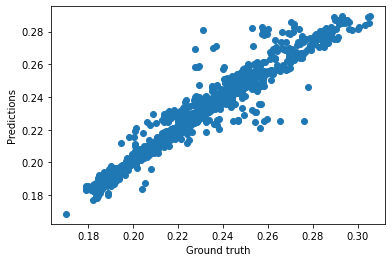

In [341]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [164]:
#%store model_fl_relative_support_x

In [165]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [166]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [332]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_support[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8213270399646955
RMSE:  0.011071373146314298
The lowest error is:  6.33875884531454e-07
The highest error is:  0.05259837024842956
The avg. error is:  0.007387049056971285


In [333]:
model_fl_relative_support_y.coef_

array([[ 6.35149238e-02, -4.15998549e-02, -1.32433736e-02,
         2.52861603e-04,  1.00710282e-01,  1.91604183e-01,
        -1.82484764e-01,  5.85253527e-01,  1.47603700e-01,
         5.39344394e-01, -8.33780381e-01,  9.68282178e-02,
         1.98060115e-02,  1.05471903e-03]])

In [336]:
model_fl_relative_support_y.intercept_

array([-0.05176077])

Text(0, 0.5, 'Predictions')

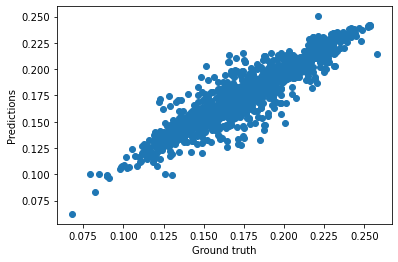

In [335]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [213]:
#%store model_fl_relative_support_y

In [214]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [215]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")